<a href="https://colab.research.google.com/github/AravindR7/Web_Scraping_Knowledge_Graphs/blob/main/Web_Scraping_Knowledge_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ensemble of Web Scraping, Computational Linguists, NLP algorithms and Graph Theory

**Knowledge graphs** are tools of data science that deals with interconnected entities(people, organization, places, events etc). Entities are the **nodes** which are connnectes via **edges**. Knowledge graph consist of these entity pairs that can be traversed to uncover meaningful connections in unstructured data.

In [1]:
# !pip install neuralcoref --no-binary neuralcoref

In [ ]:
!pip install wikipedia-api
# !pip install -U spacy

In [ ]:
!git clone https://github.com/huggingface/neuralcoref.git
!pip install -U spacy

In [ ]:
# !python -m spacy download en_core_web_lg

In [5]:
%cd neuralcoref

/content/neuralcoref


In [ ]:
!pip install -r requirements.txt
!pip install -e .

## Web Scraping

- The following function searches Wikipedia for a given topic and extracts information from the target page and its internal link.

In [3]:
import wikipediaapi  # pip install wikipedia-api
import pandas as pd
import concurrent.futures
from tqdm import tqdm

def wiki_scrape(topic_name, verbose=True):
    def wiki_link(link):
        try:
            page = wiki_api.page(link)
            if page.exists():
                return {'page': link, 'text': page.text, 'link': page.fullurl,
                        'categories': list(page.categories.keys())}
        except:
            return None

    wiki_api = wikipediaapi.Wikipedia(language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(topic_name)
    if not page_name.exists():
        print('Page {} does not exist.'.format(topic_name))
        return
    
    page_links = list(page_name.links.keys())
    progress = tqdm(desc='Links Scraped', unit='', total=len(page_links)) if verbose else None
    sources = [{'page': topic_name, 'text': page_name.text, 'link': page_name.fullurl,
                'categories': list(page_name.categories.keys())}]
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        future_link = {executor.submit(wiki_link, link): link for link in page_links}
        for future in concurrent.futures.as_completed(future_link):
            data = future.result()
            sources.append(data) if data else None
            progress.update(1) if verbose else None     
    progress.close() if verbose else None
    
    namespaces = ('Wikipedia', 'Special', 'Talk', 'LyricWiki', 'File', 'MediaWiki',
                  'Template', 'Help', 'User', 'Category talk', 'Portal talk')
    sources = pd.DataFrame(sources)
    sources = sources[(len(sources['text']) > 20)
                      & ~(sources['page'].str.startswith(namespaces, na=True))]
    sources['categories'] = sources.categories.apply(lambda x: [y[9:] for y in x])
    sources['topic'] = topic_name
    print('Pages scraped:', len(sources))
    
    return sources

In [4]:
wiki_data = wiki_scrape('COVID 19')

Links Scraped: 100%|██████████| 2024/2024 [02:09<00:00, 15.59/s]

Pages scraped: 1807


In [5]:
wiki_data.head()

,page,text,link,categories,topic
0,COVID 19,"Coronavirus disease 2019 (COVID-19), also know...",https://en.wikipedia.org/wiki/COVID-19,"[All Wikipedia articles in need of updating, A...",COVID 19
1,2020 Russia–Saudi Arabia oil price war,"On 8 March 2020, Saudi Arabia initiated a pric...",https://en.wikipedia.org/wiki/2020_Russia%E2%8...,"[2020 in Russia, 2020 in Saudi Arabia, 2020 in...",COVID 19
2,2020 Tablighi Jamaat COVID-19 hotspot in Pakistan,A Tablighi Jamaat religious congregation that ...,https://en.wikipedia.org/wiki/2020_Tablighi_Ja...,"[2020s in Pakistan, All Wikipedia articles wri...",COVID 19
3,2020 Tablighi Jamaat COVID-19 hotspot in Malaysia,A Tablighi Jamaat religious conference that to...,https://en.wikipedia.org/wiki/2020_Tablighi_Ja...,"[2020s in Malaysia, COVID-19 pandemic in Malay...",COVID 19
4,2020 Tablighi Jamaat COVID-19 hotspot in Delhi,A Tablighi Jamaat religious congregation that ...,https://en.wikipedia.org/wiki/2020_Tablighi_Ja...,"[2020s in Delhi, All Wikipedia articles writte...",COVID 19


In [11]:
# wiki_data.to_csv('wikidata.csv')

In [6]:
def wiki_page(page_name):
  wiki_api = wikipediaapi.Wikipedia(language='en',
                                    extract_format=wikipediaapi.ExtractFormat.WIKI)
  page_name = wiki_api.page(page_name)
  if not page_name.exists():
    print('Page {} does not exist.'.format(page_name))
    return

  page_data = pd.DataFrame({
      'page': page_name,
      'text': page_name.text,
      'link': page_name.fullurl,
      'categories': [[y[9:] for y in list(page_name.categories.keys())]]
  })

  return page_data

In [ ]:
!python -m spacy download en_core_web_lg

In [12]:
# %cd /content/neuralcoref

In [13]:
# !pip install -r requirements.txt
# !pip install -e .

- Knowledge graphs can be constructed automatically from text using parts of speech and dependency parsing. The extraction of entity pairs from gramatical patterns is fast and scalable to large amounts of text using NLP library SpaCy.
- The following function defines entity pairs as entities/noun chunks with subject - object dependencies connected by a root verb. Other rule-of -thumb can be used to produce different types of connections. This kind of connection can be referred to as subject-predicate object triple

In [7]:
import pandas as pd
import re
import spacy
import neuralcoref
import en_core_web_lg
nlp = en_core_web_lg.load()

# restart runtime if below line throws an error
# nlp = spacy.load('en_core_web_lg')
neuralcoref.add_to_pipe(nlp)



def get_entity_pairs(text, coref=True):
    # preprocess text
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
    if coref:
        text = nlp(text._.coref_resolved)  # resolve coreference clusters

    def refine_ent(ent, sent):
        unwanted_tokens = (
            'PRON',  # pronouns
            'PART',  # particle
            'DET',  # determiner
            'SCONJ',  # subordinating conjunction
            'PUNCT',  # punctuation
            'SYM',  # symbol
            'X',  # other
        )
        ent_type = ent.ent_type_  # get entity type
        if ent_type == '':
            ent_type = 'NOUN_CHUNK'
            ent = ' '.join(str(t.text) for t in
                           nlp(str(ent)) if t.pos_
                           not in unwanted_tokens and t.is_stop == False)
        elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
            refined = ''
            for i in range(len(sent) - ent.i):
                if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                    refined += ' ' + str(ent.nbor(i))
                else:
                    ent = refined.strip()
                    break

        return ent, ent_type

    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = []
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = spacy.util.filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span, attrs={'tag': span.root.tag,
                                            'dep': span.root.dep}) for span in spans]
        deps = [token.dep_ for token in sent]

        # limit our example to simple sentences with one subject and object
        if (deps.count('obj') + deps.count('dobj')) != 1\
                or (deps.count('subj') + deps.count('nsubj')) != 1:
            continue

        for token in sent:
            if token.dep_ not in ('obj', 'dobj'):  # identify object nodes
                continue
            subject = [w for w in token.head.lefts if w.dep_
                       in ('subj', 'nsubj')]  # identify subject nodes
            if subject:
                subject = subject[0]
                # identify relationship by root dependency
                relation = [w for w in token.ancestors if w.dep_ == 'ROOT']
                if relation:
                    relation = relation[0]
                    # add adposition or particle to relationship
                    if relation.nbor(1).pos_ in ('ADP', 'PART'):
                        relation = ' '.join((str(relation), str(relation.nbor(1))))
                else:
                    relation = 'unknown'

                subject, subject_type = refine_ent(subject, sent)
                token, object_type = refine_ent(token, sent)

                ent_pairs.append([str(subject), str(relation), str(token),
                                  str(subject_type), str(object_type)])

    ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(ent) == '' for ent in sublist)]
    pairs = pd.DataFrame(ent_pairs, columns=['subject', 'relation', 'object',
                                             'subject_type', 'object_type'])
    print('Entity pairs extracted:', str(len(ent_pairs)))

    return pairs

- Call the function on main topic page:

In [8]:
pairs = get_entity_pairs(wiki_data.loc[0,'text'])

Entity pairs extracted: 50


### Coreference Resolution
- It significantly improves entity pair extraction by normalizing the text, removing redundancies and assigning entity pronouns.


- Lets Draw the network using NetworkX library. I will createa directed multigraph network with nodes sized in proportion to degree centrality.

In [12]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(120, 90), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='green',
        edgecolors='green',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

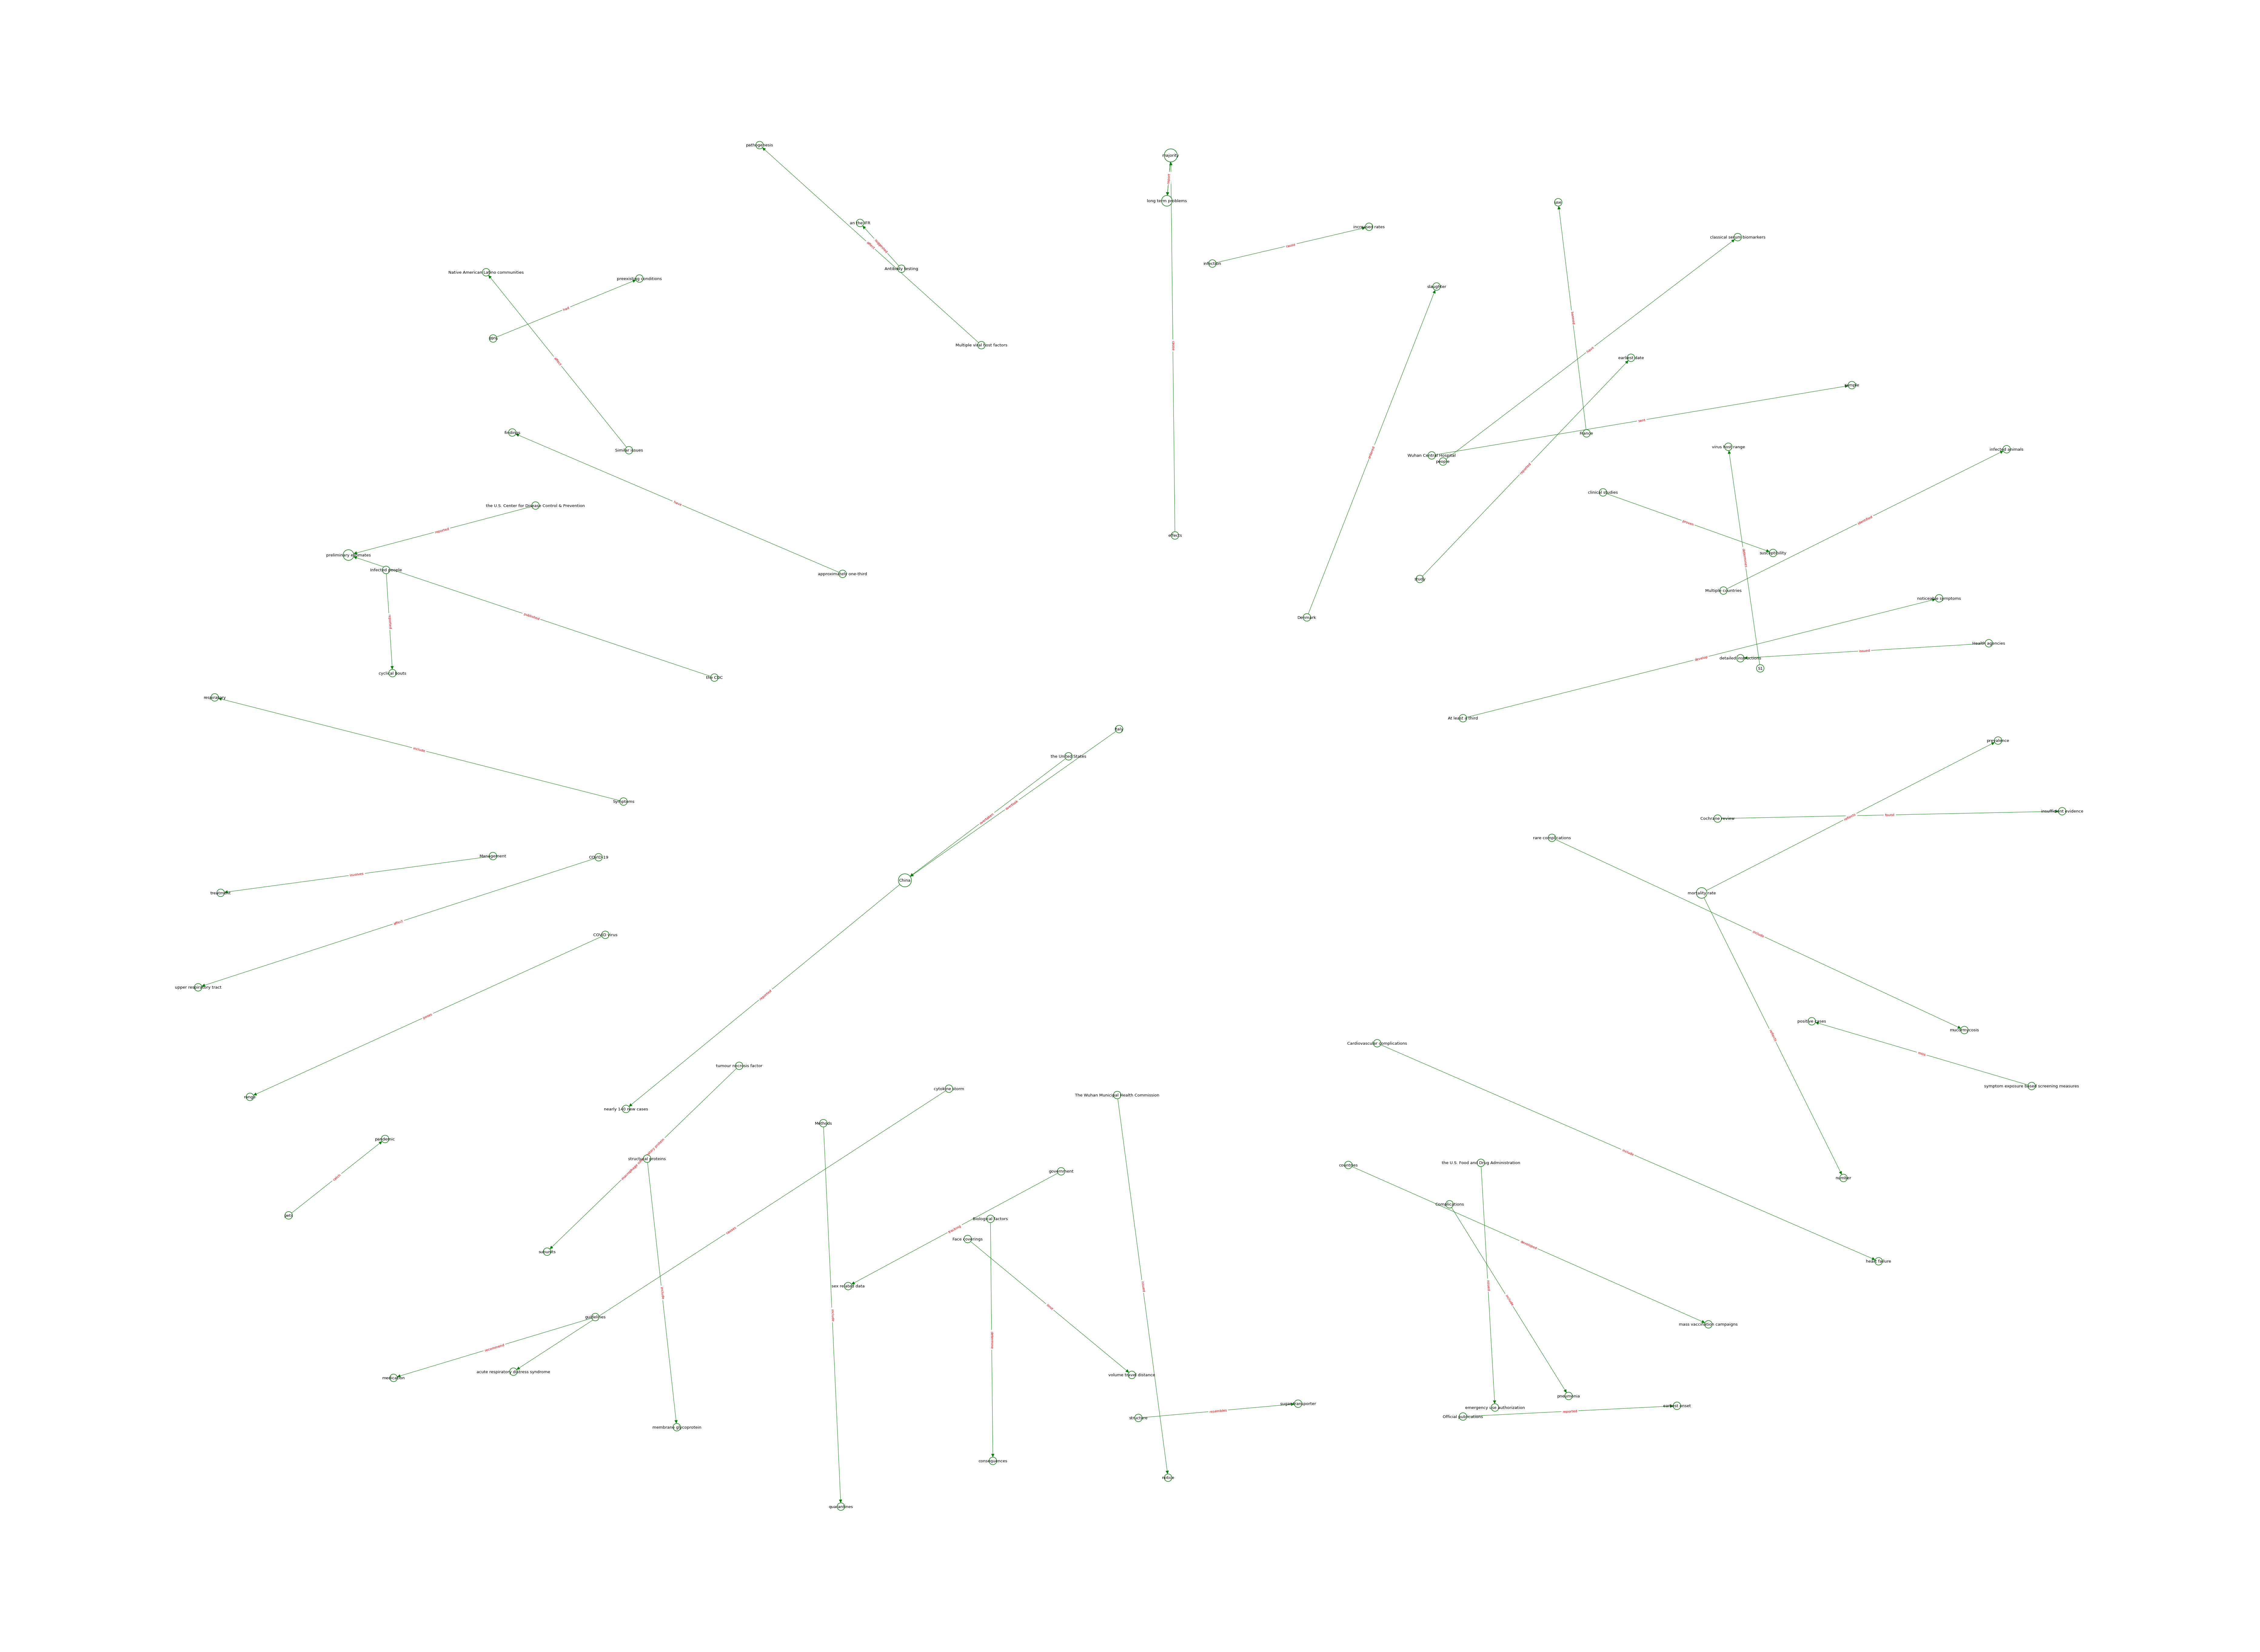

In [13]:
draw_kg(pairs)

- If a draw graph becomes unintelligible we can increase the figure size or filter/query.

In [14]:
def filter_graph(pairs, node):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    edges = nx.dfs_successors(k_graph, node)
    nodes = []
    for k, v in edges.items():
        nodes.extend([k])
        nodes.extend(v)
    subgraph = k_graph.subgraph(nodes)
    layout = (nx.random_layout(k_graph))
    nx.draw_networkx(
        subgraph,
        node_size=1000,
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white'
        )
    labels = dict(zip((list(zip(pairs.subject, pairs.object))),
                    pairs['relation'].tolist()))
    edges= tuple(subgraph.out_edges(data=False))
    sublabels ={k: labels[k] for k in edges}
    nx.draw_networkx_edge_labels(subgraph, pos=layout, edge_labels=sublabels,
                                font_color='red')
    plt.axis('off')
    plt.show()

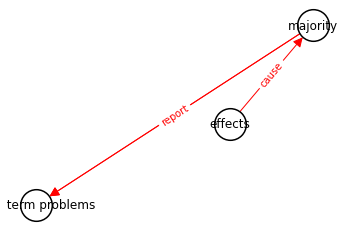

In [15]:
filter_graph(pairs, 'effects')

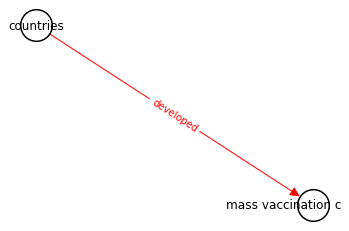

In [16]:
filter_graph(pairs, 'countries')

In [17]:
wiki_data1 = wiki_scrape('Covid-19')

Links Scraped: 100%|██████████| 2024/2024 [01:43<00:00, 19.57/s]

Pages scraped: 1808


In [29]:
pairs1 = get_entity_pairs(wiki_data.loc[120,'text'])

Entity pairs extracted: 12


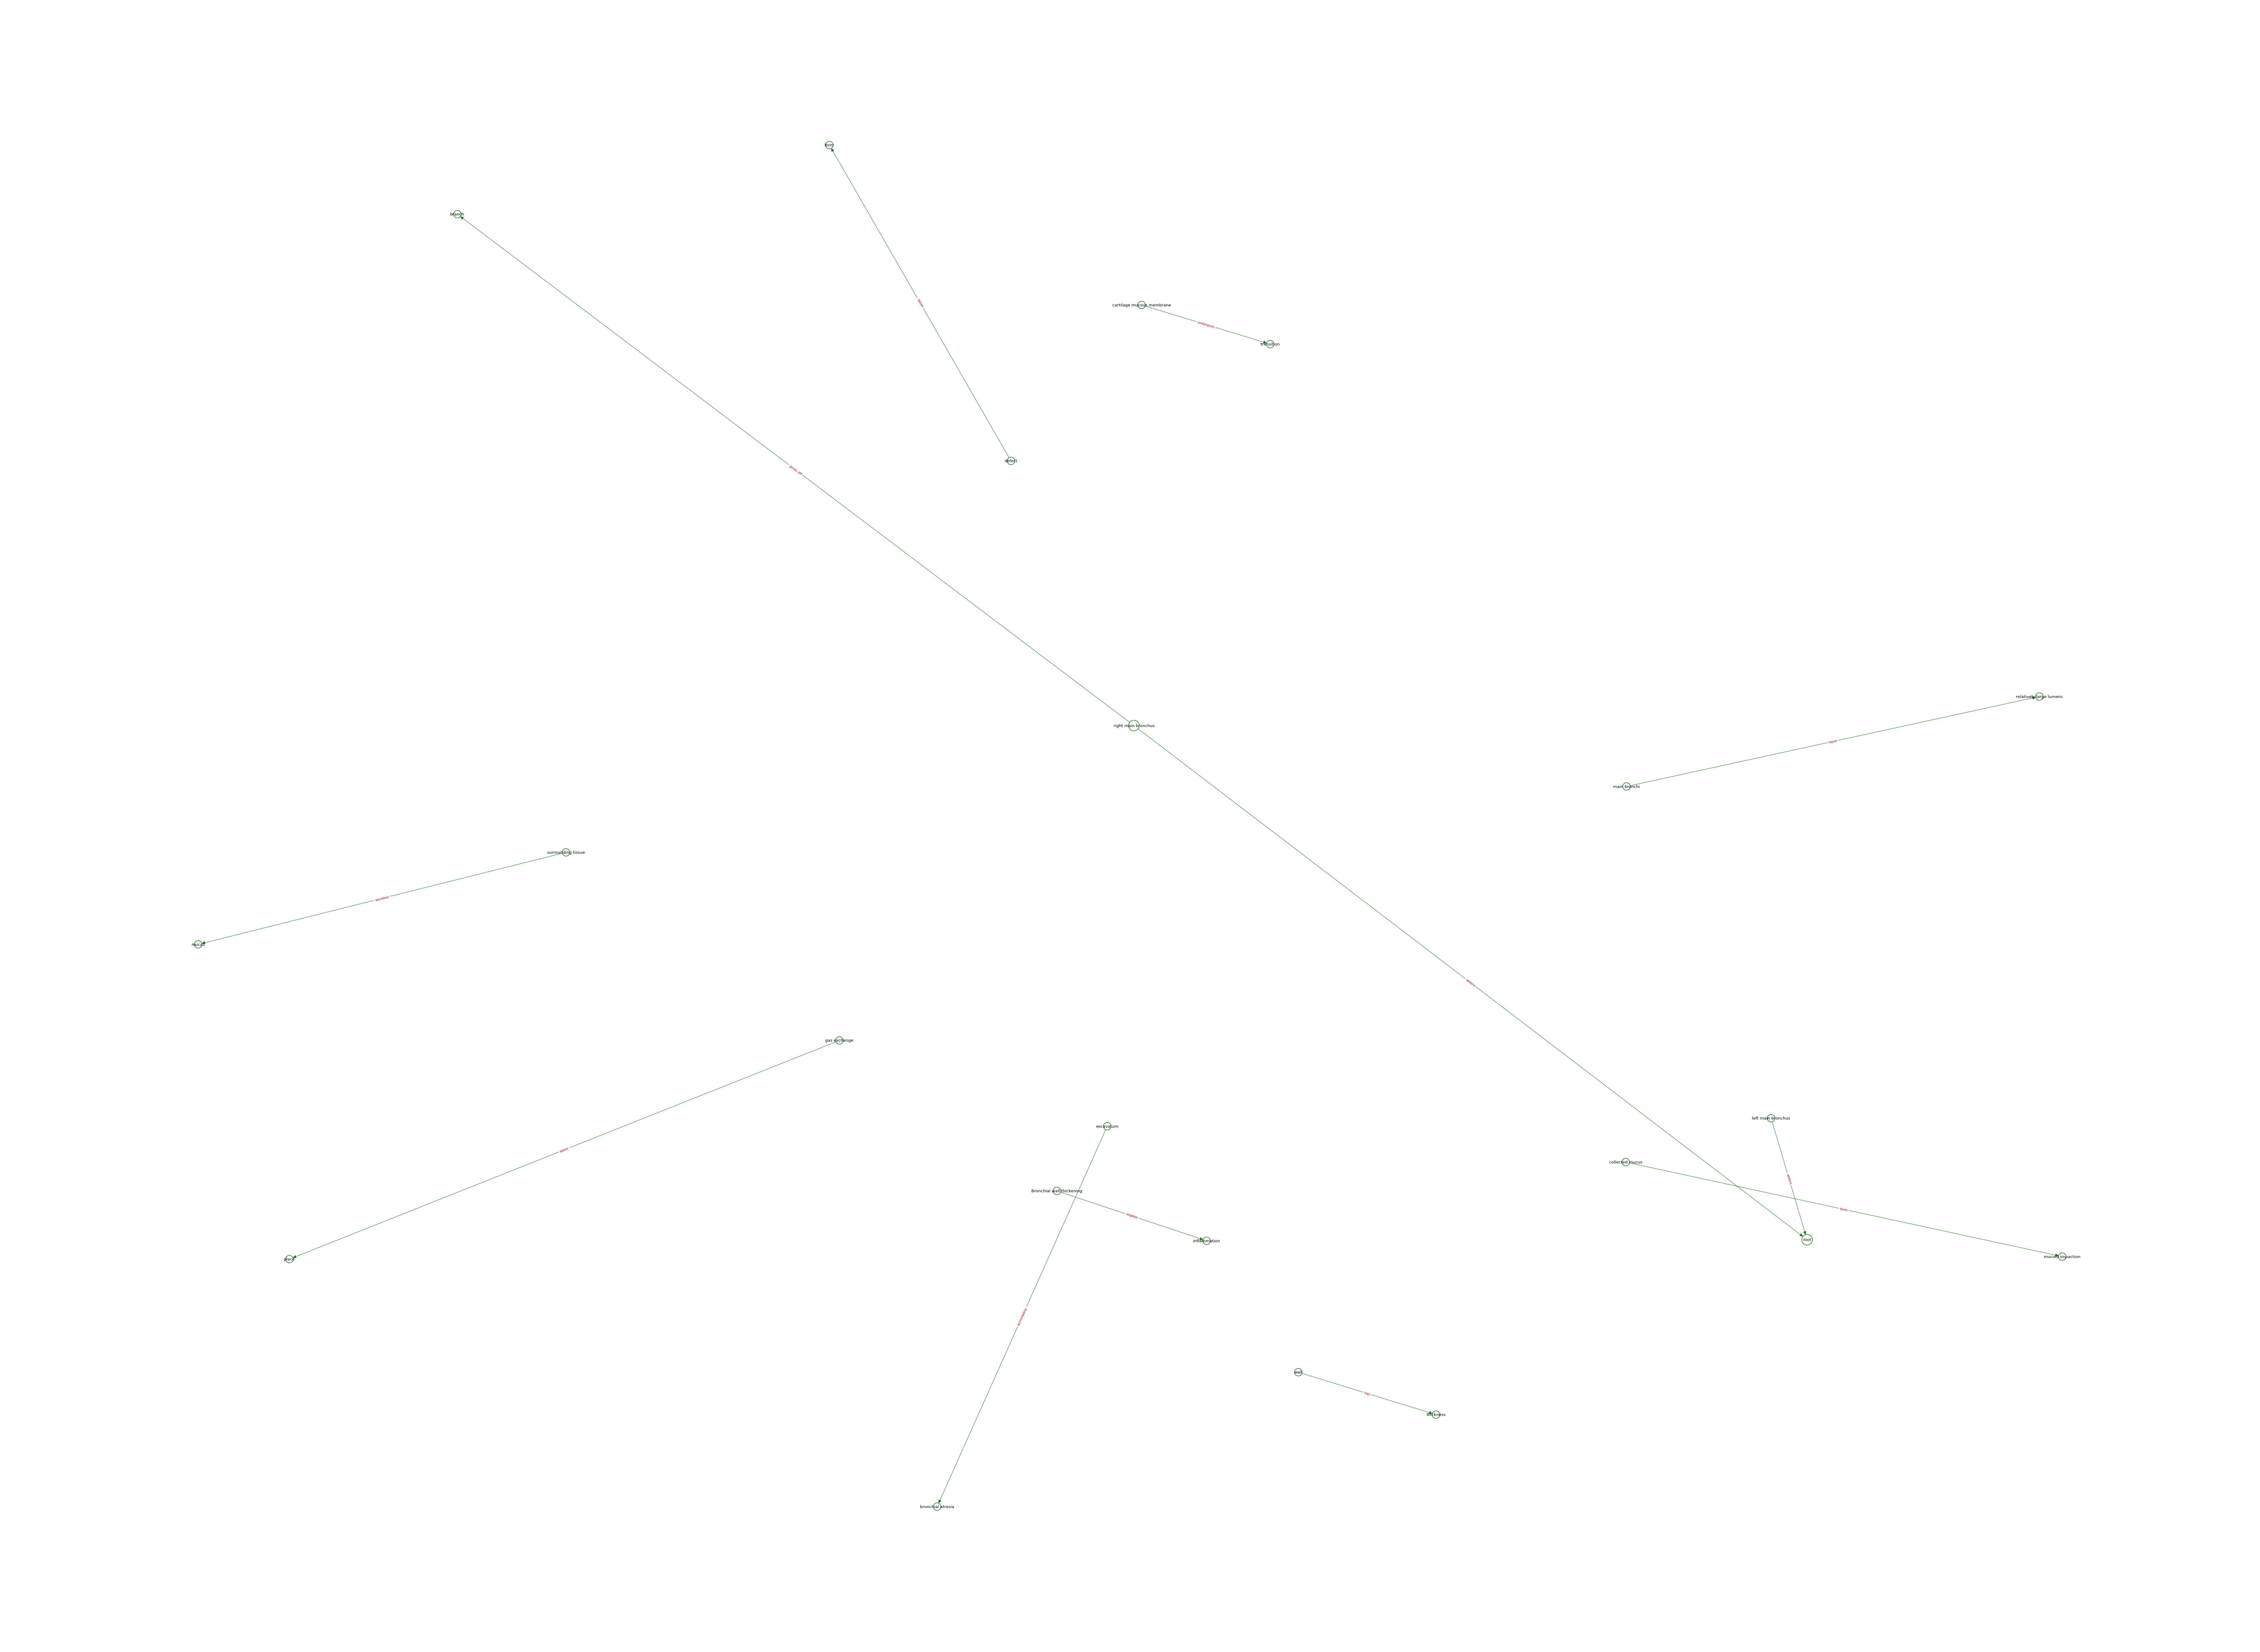

In [30]:
draw_kg(pairs1)

## Text Similarity

In [31]:
def jaccard_similarity(doc1, doc2):

  # list unique words in the document
  words_doc1 = set(doc1.lower().split())
  words_doc2 = set(doc2.lower().split())

  # find the intersection of words list of doc1 & doc2
  intersection = words_doc1.intersection(words_doc2)

  # find the union of words list of doc1 & doc2
  union = words_doc1.union(words_doc2)

  # Calculate Jaccard similarity score
  # using the length of intersection set divided by the length of union set 
  return float(len(intersection)) / len(union)

In [32]:
docu_1 = "Work from home is the new normal in digital world"
docu_2 = "Work from home is normal"

jaccard_similarity(docu_1, docu_2)

0.5